In [1]:
%matplotlib inline
from nldi_xstool.XSGen import XSGen
from nldi_xstool.dem_query import query_dems_shape
from nldi_xstool.nldi_xstool import getXSAtPoint, getXSAtEndPts
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import requests
try:
    from nldi_xstool.__openChannel import flowEst
except ImportError:
    from .__openChannel import flowEst

In [2]:
# The following function converts NGVD29 to NAVD88 if gage is in NGVD29 using NOAA NGS Vertcon service api
# https://www.ngs.noaa.gov/web_services/ncat/lat-long-height-service.shtml

def getGageDatum(gagenum, verbose=False):
    si = nwis.get_record(sites=gagenum, service='site')
    if si['alt_datum_cd'].values[0] == 'NGVD29':
#         print('conversion')
        url = "https://www.ngs.noaa.gov/api/ncat/llh"
        lat_str = 'lat_va'
        lon_str = 'long_va'

        alt_str = 'alt_va'
        indatum_str = 'coord_datum_cd'
        outdatum_str = 'NAD83(2011)'
        inVertDataum_str = 'NGVD29'
        outVertDataum = 'NAVD88'
        if f'{si[indatum_str].values[0]}' == 'NAD83':
            indatum = 'NAD83(2011)'
        else:
            indatum = f'{si[indatum_str].values[0]}'

        ohgt = float(si[alt_str].values[0])*.3048
        
        tmplonstr = si[lon_str].values[0]

        if len(str(tmplonstr)) == 6:
            tstr = '0'
            tmplonstr = (tstr + str(tmplonstr))

        payload = {
            'lat':f'N{si[lat_str].values[0]}',
            'lon':f'W{tmplonstr}',
            'orthoHt': repr(ohgt),
            'inDatum':indatum,
            'outDatum':outdatum_str,
            'inVertDatum':inVertDataum_str,
            'outVertDatum':outVertDataum 
        }
        r = requests.get(url, params=payload)
        resp = r.json()
        if verbose:
            print(f'{si[indatum_str].values[0]}')
            print(f'payload: {payload}')
            print(resp)
        return float(resp['destOrthoht'])
    else:
#         print('non-conversion')
        return si['alt_va'].values[0]*.3048

In [3]:
gage_ids = [
    "02334480",
    "02335350",
    "02207055",
    "03321350",
    "06811500",
    "02312200",
    "02312645",
    "02149000",
    "01100561"]

tmp_gage_id = "11424550" # gage has no comid so can't use xsatpoint function

In [4]:
# Bankfull geometry: https://www.sciencebase.gov/catalog/item/5cf02bdae4b0b51330e22b85
bf_geom = pd.read_csv('../BANKFULL_CONUS/BANKFULL_CONUS.txt')
gage_datum_m = []
gage_comid = []
bf_width = []
best_dem_res = []
cross_sections = []
for index, gage in enumerate(gage_ids):
    
    gage_datum_m.append(getGageDatum(gage, verbose=False))
    gageloc = NLDI().getfeature_byid('nwissite', f'USGS-{gage}')
    gage_comid.append(gageloc.comid.values.astype(int)[0])
    bf_width.append(bf_geom.loc[bf_geom['COMID'] == gage_comid[index]]['BANKFULL_WIDTH'].values[0])
    x = gageloc.geometry.x[0]
    y = gageloc.geometry.y[0]
    print(gage, x, y, gage_comid[index], gage_datum_m[index], bf_width[index])
    cross_sections.append(getXSAtPoint((x,y), width=bf_width[index]*10, numpoints=101, res=1.0))

FileNotFoundError: [Errno 2] No such file or directory: '../BANKFULL_CONUS/BANKFULL_CONUS.txt'

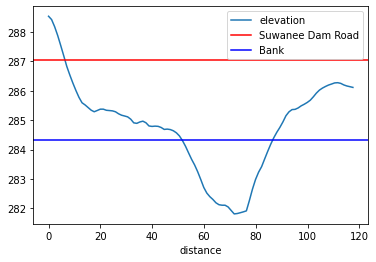

In [5]:
fig, ax = plt.subplots()
cross_sections[0].plot.line(x='distance', y='elevation', ax=ax)
ax.axhline(y=287.039, color='r', linestyle='-', label='Suwanee Dam Road')
ax.axhline(y=284.332, color='b', linestyle='-', label='Bank')
ax.legend()

In [6]:
xspts = [(-84.069592, 34.132959), (-84.070461,  34.131941)]
xs2 = getXSAtEndPts(xspts, 101, res=1.0)

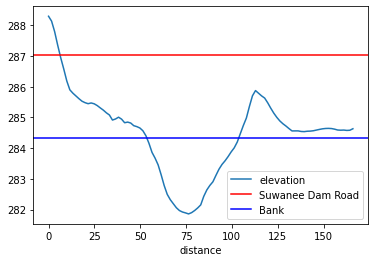

In [7]:
fig, ax = plt.subplots()
xs2.plot.line(x='distance', y='elevation', ax=ax)
ax.axhline(y=287.039, color='r', linestyle='-', label='Suwanee Dam Road')
ax.axhline(y=284.332, color='b', linestyle='-', label='Bank')
ax.legend()

In [8]:
gageloc

,,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
USGS-01100561,0,POINT (-71.20839 42.74315),nwissite,NWIS Sites,USGS-01100561,"SPICKET RIVER NEAR METHUEN, MA",https://waterdata.usgs.gov/monitoring-location...,6744772,01070006000369,43.8444000000,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [9]:
gage_datum_m

[281.6352,
 265.11504,
 254.8128,
 121.810272,
 271.316,
 17.734,
 -0.247,
 248.332,
 30.522672]

In [10]:
bf_geom = pd.read_csv('../BANKFULL_CONUS/BANKFULL_CONUS.txt')
bf_geom

,COMID,BANKFULL_WIDTH,BANKFULL_DEPTH,BANKFULL_XSEC_AREA
0,-504212,-9999.00,-9999.00,-9999.00
1,-504211,-9999.00,-9999.00,-9999.00
2,-504210,-9999.00,-9999.00,-9999.00
3,-504209,-9999.00,-9999.00,-9999.00
4,-504208,-9999.00,-9999.00,-9999.00
...,...,...,...,...
2699859,948100736,2.81,0.15,0.38
2699860,948100737,10.04,0.40,3.76
2699861,948100738,8.13,0.34,2.57
2699862,948100739,15.98,0.58,8.73


In [11]:
bf_geom = pd.read_csv('../BANKFULL_CONUS/BANKFULL_CONUS.txt')
gageloc = NLDI().getfeature_byid('nwissite', f'USGS-{gage_ids[0]}')
comid = gageloc.comid.values.astype(int)[0]
# print(comid[0])
bf_width = bf_geom.loc[bf_geom['COMID'] == comid]['BANKFULL_WIDTH'].values[0]
x = gageloc.geometry.x[0]
y = gageloc.geometry.y[0]


In [12]:
print(float(bf_width)*2.0)
xs = getXSAtPoint((x,y), width=bf_width*2, numpoints=101, res=1.0)
xs

23.5
5


,elevation,distance,geometry
z,,,
0,284.681277,0.000,POINT (-84.06985 34.13266)
1,284.675236,0.235,POINT (-84.06985 34.13266)
2,284.668149,0.470,POINT (-84.06985 34.13266)
3,284.660017,0.705,POINT (-84.06985 34.13266)
4,284.650840,0.940,POINT (-84.06985 34.13265)
...,...,...,...
96,282.030893,22.560,POINT (-84.06998 34.13253)
97,282.007804,22.795,POINT (-84.06998 34.13253)
98,281.984510,23.030,POINT (-84.06998 34.13253)


In [13]:
bf_width

11.75

In [14]:
xs["distance"].values

array([ 0.   ,  0.235,  0.47 ,  0.705,  0.94 ,  1.175,  1.41 ,  1.645,
        1.88 ,  2.115,  2.35 ,  2.585,  2.82 ,  3.055,  3.29 ,  3.525,
        3.76 ,  3.995,  4.23 ,  4.465,  4.7  ,  4.935,  5.17 ,  5.405,
        5.64 ,  5.875,  6.11 ,  6.345,  6.58 ,  6.815,  7.05 ,  7.285,
        7.52 ,  7.755,  7.99 ,  8.225,  8.46 ,  8.695,  8.93 ,  9.165,
        9.4  ,  9.635,  9.87 , 10.105, 10.34 , 10.575, 10.81 , 11.045,
       11.28 , 11.515, 11.75 , 11.985, 12.22 , 12.455, 12.69 , 12.925,
       13.16 , 13.395, 13.63 , 13.865, 14.1  , 14.335, 14.57 , 14.805,
       15.04 , 15.275, 15.51 , 15.745, 15.98 , 16.215, 16.45 , 16.685,
       16.92 , 17.155, 17.39 , 17.625, 17.86 , 18.095, 18.33 , 18.565,
       18.8  , 19.035, 19.27 , 19.505, 19.74 , 19.975, 20.21 , 20.445,
       20.68 , 20.915, 21.15 , 21.385, 21.62 , 21.855, 22.09 , 22.325,
       22.56 , 22.795, 23.03 , 23.265, 23.5  ])

<AxesSubplot:xlabel='distance', ylabel='elevation'>

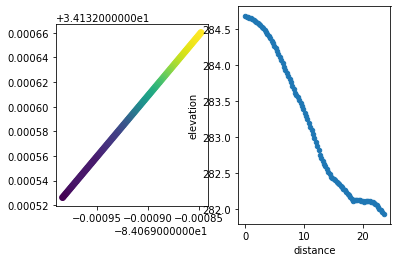

In [15]:
fig, ax = plt.subplots(1,2)
xs.plot('elevation', ax=ax[0])
xs.plot.scatter(x='distance', y='elevation', ax=ax[1])

In [16]:
gageloc = NLDI().getfeature_byid('nwissite', f'USGS-{gage_ids[0]}').to_crs('epsg:3857')
comid = gageloc.comid.values.astype(str)
gage_strmseg = NLDI().getfeature_byid("comid", comid[0]).to_crs('epsg:3857')

In [17]:
gageloc

,,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
USGS-02334480,0,POINT (-9358629.716 4046607.161),nwissite,NWIS Sites,USGS-02334480,"RICHLAND CREEK AT SUWANEE DAM ROAD, NEAR BUFOR...",https://waterdata.usgs.gov/monitoring-location...,2044673,03130001001331,63.3317600000,https://labs.waterdata.usgs.gov/api/nldi/linke...


5


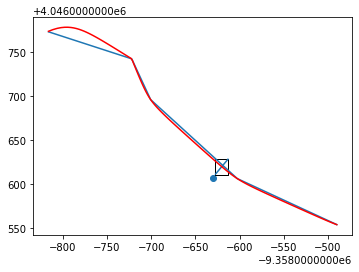

In [18]:
xs = XSGen(point=gageloc, cl_geom=gage_strmseg, ny=101, width=23.5, tension=10.0)
xs_line = xs.get_xs()
ax = plt.subplot(111)
gageloc.plot(ax=ax)
gage_strmseg.plot(ax=ax)
xs_line.plot(ax=ax)
xs.get_strm_seg_spline().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
plt.show()

In [19]:
xs_line_geom = xs_line.to_crs('epsg:4326')
print(xs_line_geom)
bbox = xs_line_geom.geometry[0].envelope.bounds
print(bbox)
query = query_dems_shape(bbox)
print(query)

            name                                           geometry
0  cross-section  LINESTRING (-84.06985 34.13266, -84.06985 34.1...
(-84.06998346587933, 34.13252625758786, -84.06984775064427, 34.13266010187424)
{'res_1m': False, 'res_3m': True, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


In [20]:
bbox = xs_line.geometry[0].bounds
width = abs(bbox[0]-bbox[2])
height = abs(bbox[1]-bbox[3])
print(width, height)
bb = xs_line.buffer(100)
bb.geometry[0].bounds

15.107750859111547 18.000162887386978


(-9358727.74433448, 4046510.9825387206, -9358512.648755891, 4046728.9705293356)

(-9358727.744334482, -9358512.64875589, 4046510.9825387206, 4046791.0424907836)

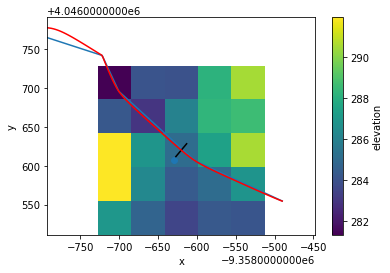

In [21]:
t1 = (xs_line.total_bounds) + ((-100.,-100.,100., 100.))
dem = py3dep.get_map("DEM", bb.geometry[0].bounds, resolution=30.0, geo_crs="EPSG:3857", crs="epsg:3857")

ax = plt.subplot(111)
gage_strmseg.plot(ax=ax)
xs_line.plot(ax=ax, colors='black')
xs.get_strm_seg_spline().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
dem.plot(ax=ax)
gageloc.plot(ax=ax)
ax.axis('equal')

In [ ]:
# test save cross-sections to .csv
f = open('test_out.csv', 'a')
for df in cross_sections:
    df.to_csv(f)
f.close()